In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
pollution = pd.read_csv("/Users/monicaclairew/Documents/south-korean-pollution-data.csv",
                       parse_dates=['date'],
                       index_col='date')

In [3]:
pollution

,Unnamed: 0,pm25,pm10,o3,no2,so2,co,Lat,Long,City,District,Country
date,,,,,,,,,,,,
2022-02-01,0,112,31,35,2,1,4,38.2089,127.9495,Bangsan-Myeon,Gangwon,South Korea
2022-02-02,1,92,21,35,2,1,0,38.2089,127.9495,Bangsan-Myeon,Gangwon,South Korea
2022-02-03,2,60,20,35,1,1,4,38.2089,127.9495,Bangsan-Myeon,Gangwon,South Korea
2022-02-04,3,51,27,33,1,1,4,38.2089,127.9495,Bangsan-Myeon,Gangwon,South Korea
2022-02-05,4,57,24,27,2,1,5,38.2089,127.9495,Bangsan-Myeon,Gangwon,South Korea
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11,34525,49,43,46,3,1,4,37.5082,130.8217,Taeha-Ri,Gyeongbuk,South Korea
2022-02-12,34526,102,24,39,2,0,3,37.5082,130.8217,Taeha-Ri,Gyeongbuk,South Korea
2022-02-13,34527,59,15,40,2,0,0,37.5082,130.8217,Taeha-Ri,Gyeongbuk,South Korea


In [4]:
pollution = pollution[pollution.City == 'Jeongnim-Dong'].pm25.sort_index()
start = pd.to_datetime('2018-01-01')
end = pd.to_datetime('2022-01-01')
pollution = pollution [start:end]
print ('Sample of time series Pollution data')
pollution.head()

Sample of time series Pollution data


date
2018-01-01    72
2018-01-02    95
2018-01-03    57
2018-01-04    70
2018-01-05    88
Name: pm25, dtype: int64

In [5]:
a = pd.date_range(start="2018-01-01", end="2022-01-01", freq="D")
b = pollution.index
diff_dates = a.difference(b)

td = pd.Timedelta(1, "d")
for date in diff_dates: 
    prev_val = pollution[date-td]
    pollution[date] = prev_val
    
pollution.sort_index(inplace=True)
pollution.freq = "D"

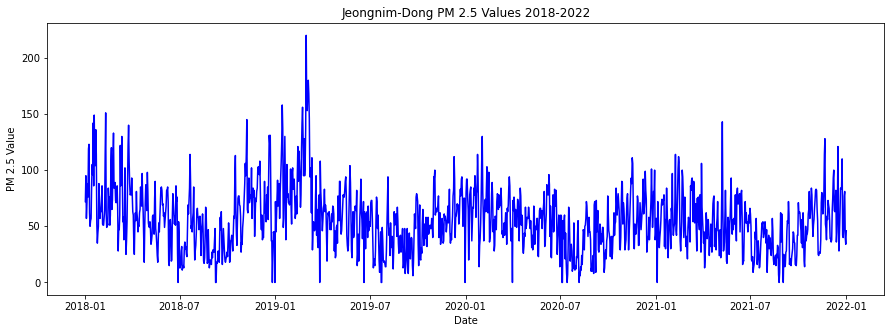

In [6]:
fig = plt.figure(figsize=(15,5))
plt.plot(pollution, color='blue')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Jeongnim-Dong PM 2.5 Values 2018-2022')
plt.show()

In [7]:
end_train_ix = pd.to_datetime('2020-12-31')
train = pollution[:end_train_ix]
test = pollution[end_train_ix:]

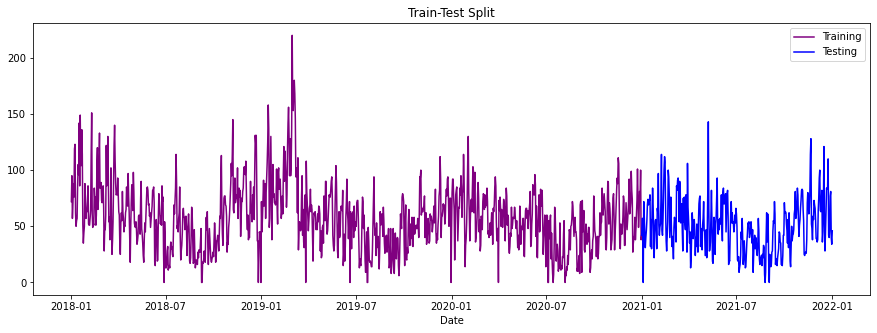

In [8]:
fig = plt.figure(figsize=(15,5))
plt.plot(train, color='purple', label='Training')
plt.plot(test, color='blue', label='Testing')
plt.xlabel('Date')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [9]:
WINDOW = 14

train_data = tf.data.Dataset.from_tensor_slices(train.values)

train_data = train_data.window(WINDOW+1, shift=1, drop_remainder=True)

train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

train_data = train_data.map(lambda x: (x[:-1], x[-1]))

train_data = train_data.shuffle(1_000)

train_data = train_data.batch(32).prefetch(1)

2022-05-06 10:31:57.730660: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
from tensorflow.keras.callbacks import Callback

In [11]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mse') < 10.0:
            print("MSE under 10.0")
            self.model.stop_training = True
            
my_callback = CustomCallback()

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

lstm_model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mse']
)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 14, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 14, 256)          133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [14]:
lstm_history = lstm_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

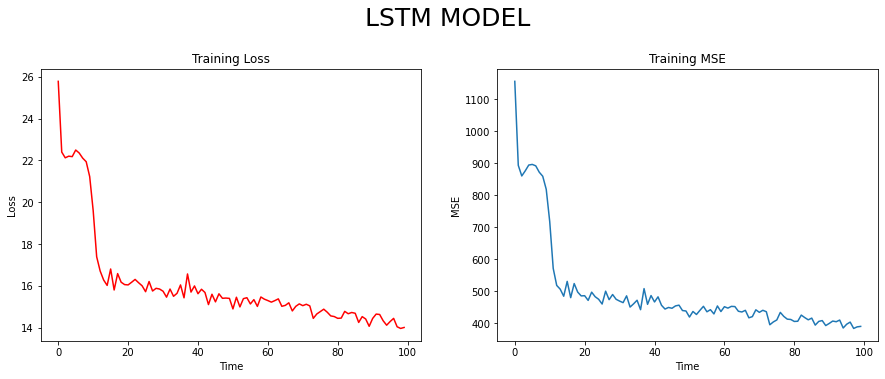

					FINAL LOSS: 14.02 | FINAL MSE: 390.26


In [15]:
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['mse'])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('MSE')
axs[1].set_title('Training MSE')
            
fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MSE: {}". format(
                                                round(lstm_history.history['loss'][-1], 2),
                                                 round(lstm_history.history['mse'][-1], 2)))

In [16]:
my_models = [('LSTM MODEL', lstm_model)]
model_forecasts = {
    'LSTM MODEL' : []
}

forecast_data = train[-WINDOW:].append(test[:-1]).values
             
for name, model in my_models:
    test_data = tf.data.Dataset.from_tensor_slices(forecast_data)
    test_data = test_data.window(WINDOW, shift=1, drop_remainder=True)
    test_data = test_data.flat_map(lambda x: x.batch(WINDOW+1))
    test_data = test_data.batch(32).prefetch(1)
    preds = model.predict(test_data)
    model_forecasts[name].append(preds)    

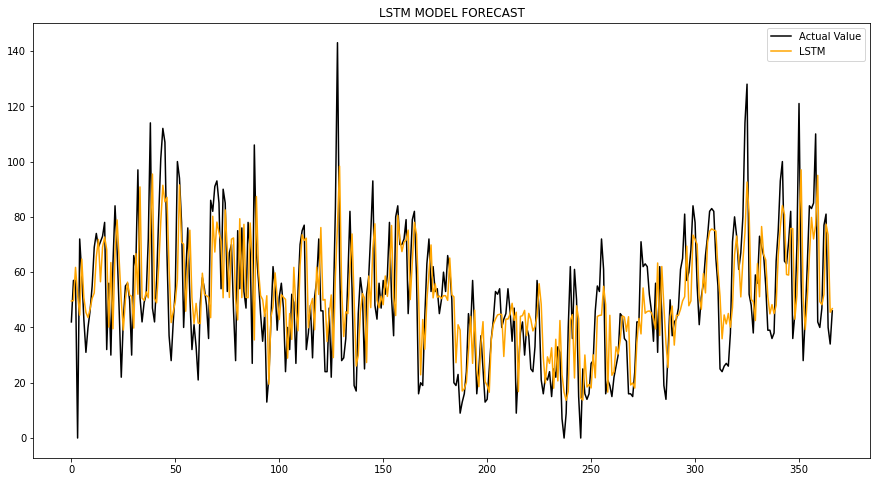

In [17]:
plt.rcParams["figure.figsize"] = (15,8)


plt.plot(test.values, color='black', label='Actual Value')
plt.plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='orange', label='LSTM')
plt.title("LSTM MODEL FORECAST")
            
plt.legend()
plt.show()